# Window_shift

In [297]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random
random.seed(666)

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [298]:
meta = {}
meta[45] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_162032', 'del_units':[594], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[46] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_180855', 'del_units':None, 'vis_mice':np.array(['nan', 'alpha', 'beta'])}
meta[11] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-06_154258', 'del_units':[847, 835], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[13] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_120055', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[14] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_122629', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[19] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_140410', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[20] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-15_110539', 'del_units':[33], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}


In [299]:
Session = 20

In [300]:
mouse = meta[Session]['mouse']
ks = meta[Session]['ks']
del_units=meta[Session]['del_units']
vis_mice = meta[Session]['vis_mice']
active_blocks = [1,2,3]


In [301]:
a_idx = np.where(vis_mice=='alpha')[0][0]
b_idx = np.where(vis_mice=='beta')[0][0]
bl_idx = 3 

In [302]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift')
except:
    pass

# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}')
except:
    pass

try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\clusts')
except:
    pass

### Ephys data

In [303]:
KSdir = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\{ks}\\'

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

In [304]:
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
goods = []
for clust in goodclusts :
    goods.append(clust)
print(f'Session {Session}: {len(goods)} good clusters')

Session 20: 17 good clusters


In [305]:
goodspiketimes = {}

spikethresh = 1000 # min nb of spikes
for goodunit in goods :
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : 
        goodspiketimes[goodunit] = spiketimes[goodinds]

In [306]:
len(goodspiketimes.keys())

17

### Behavior data

In [307]:
matfile = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\Behaviour.mat'
EvaBehavior = loadmat(matfile)

In [308]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [309]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12)

### Firing rates

In [310]:
import copy

In [311]:
def fr_matrix_prep(beforesamples, aftersamples, blocks, bins, del_units=None):
    # discard wierd cells based on rasters
    goodspiketimes_copy = copy.deepcopy(goodspiketimes)

    try:
        for unit in del_units:
            del goodspiketimes_copy[unit]
    except:
        pass

    units = goodspiketimes_copy.keys()
    fr_dic = {}
   
    for block in blocks:
        n_trials = TestSocialSampleWindowPerTrial[block].shape[0]
        n_units = len(goodspiketimes_copy.keys())

        fr_matrix = np.zeros((n_trials, n_units))

        i = 0
        for unit in units: # list of good cluster_id
            
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes_copy[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes_copy[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes = goodspiketimes_copy[unit][np.intersect1d(cond1,cond2)].astype(int)-onset

                n = np.histogram(unitspikes, bins=bins)[0][0]
                fr = n/0.25
                fr_matrix[event, i] = fr
            i+=1
                
        fr_dic[block] = fr_matrix
    
    return fr_dic

In [312]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
blocks = [1,2,3]
npoke_window = 0.25
eventlength = npoke_window*samplplimg_rate # 0.25 s
binsize = 0.25*samplplimg_rate 


In [313]:
shift_list = []

x=1
for i in range(41): # from -1sec to +1sec around 250ms window (1+1+0.25=2.25); slide by 0.05; 
    beforesamples = x*samplplimg_rate 
    aftersamples = -beforesamples
    x = x-0.05

    bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)
    fr_dic = fr_matrix_prep(beforesamples, aftersamples, blocks, bins, del_units=del_units)

    shift_list.append(fr_dic)

In [314]:
shift_list[0][1].shape

(30, 16)

In [315]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\{mouse}_S{Session}_shift_list.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(shift_list, f)

so basically it s a list containing firing_rates_dic for different behav windows; from -1 sec to 1 sec (in order: 1st el in the list = -1sec; 2nd = -0.95, etc)

In [316]:
shift_list[1][2].shape # raws - trials; col - neurons

(30, 16)

In [317]:
shift_list[1].keys()

dict_keys([1, 2, 3])

## PCA

In [318]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import multivariate_normal
import matplotlib.patches as patches

In [319]:
data = []
for i in range(41):
    data.append(np.concatenate((shift_list[i][a_idx], shift_list[i][b_idx], shift_list[i][bl_idx]),axis=0))

In [320]:
data[0].shape

(90, 16)

In [321]:
# Assuming `data` is a list of 2D matrices, one for each time window
# Each matrix has shape (n_trials, n_neurons)

# Concatenate matrices to form a 3D tensor
tensor = np.stack(data, axis=0)  # Shape: (n_time_windows, n_trials, n_neurons)

save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\{mouse}_S{Session}_shift_tensor.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(tensor, f)

In [322]:
# Reshape tensor to 2D matrix
n_time_windows, n_trials, n_neurons = tensor.shape
reshaped_data = tensor.reshape(n_time_windows * n_trials, n_neurons)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(reshaped_data)

# Apply PCA
pca = PCA(n_components=2)  # Choose number of components based on explained variance
principal_components = pca.fit_transform(scaled_data)

# Scale each principal component to range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
principal_components = scaler.fit_transform(principal_components)  

# Reshape back to (n_time_windows, n_trials, n_components)
principal_components = principal_components.reshape(n_time_windows, n_trials, -1)

# `principal_components` now contains the reduced dimensionality data

In [323]:
principal_components.shape

(41, 90, 2)

In [324]:
k = int(principal_components.shape[1]/3)
a_pca = principal_components[:,:k,:]
b_pca = principal_components[:,k:k+k,:]
c_pca = principal_components[:,k+k:,:]
a_pca.shape, b_pca.shape, c_pca.shape

((41, 30, 2), (41, 30, 2), (41, 30, 2))

In [325]:
def fit_gaussian(data):
    """Fit a 2D Gaussian to the data and return the mean and covariance."""
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    return mean, cov

def plot_ellipse(mean, cov, ax, n_std=1.0, color='red', **kwargs):
    """Plot an ellipse representing the Gaussian mean ± n_std * standard deviations."""
    # Eigenvalue decomposition to find the axis lengths and rotation angle
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    # Width and height are "full" lengths, not radius
    width, height = 2 * n_std * np.sqrt(vals)
    
    ell = patches.Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=None, facecolor=color, alpha=0.35, **kwargs)
    ax.add_patch(ell)

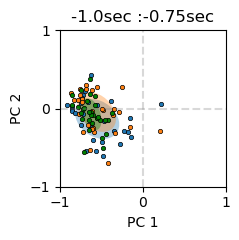

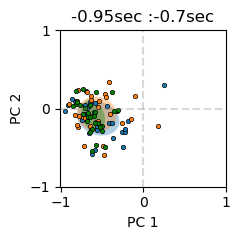

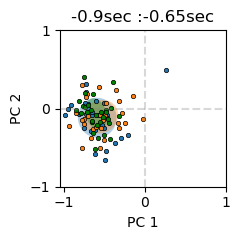

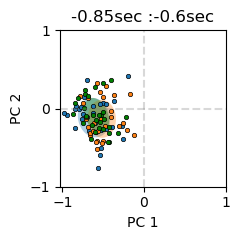

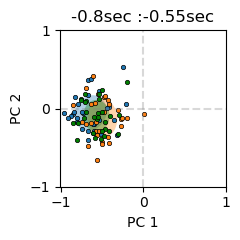

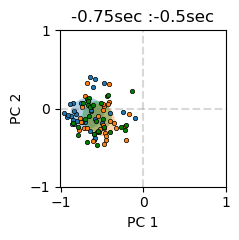

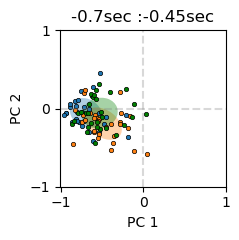

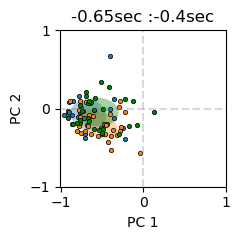

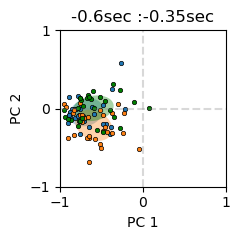

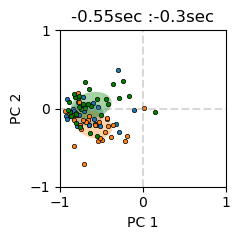

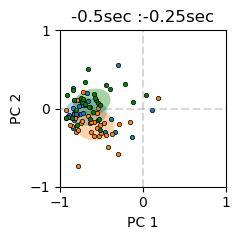

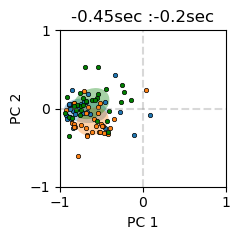

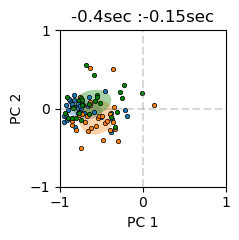

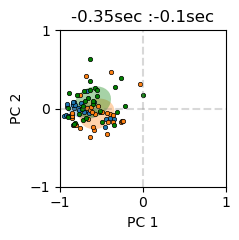

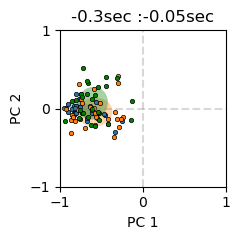

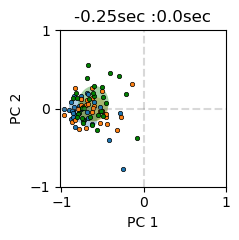

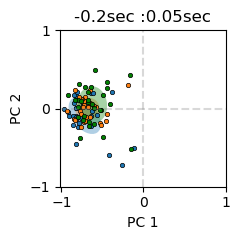

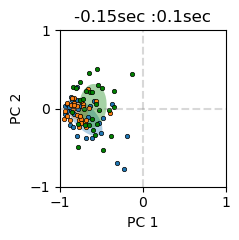

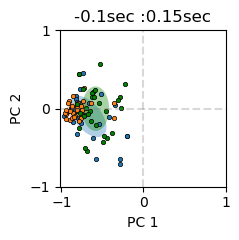

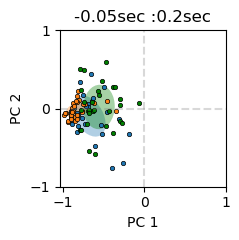

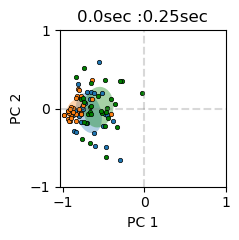

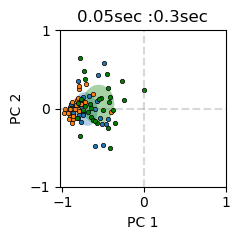

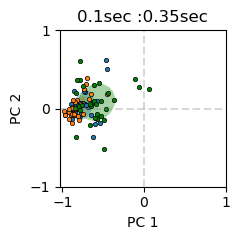

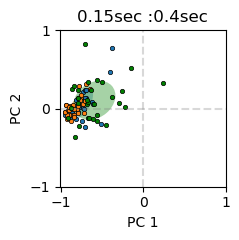

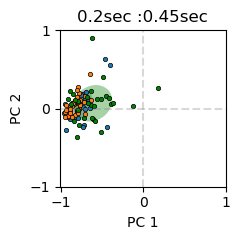

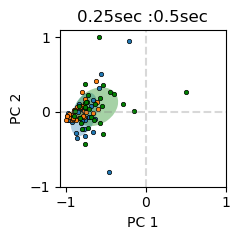

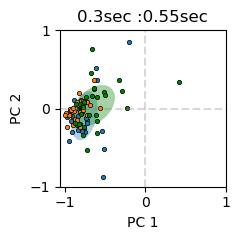

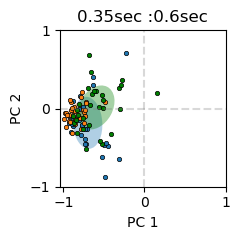

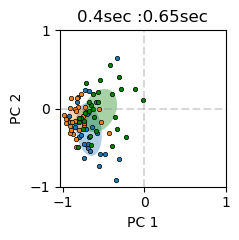

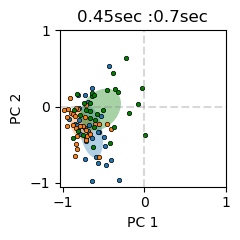

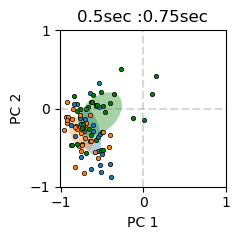

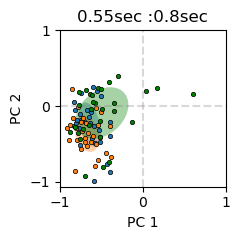

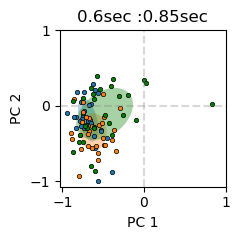

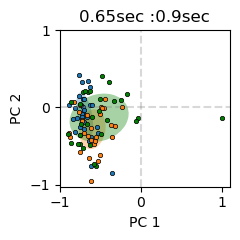

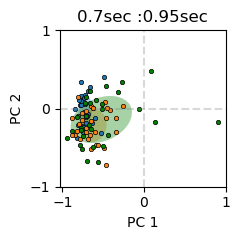

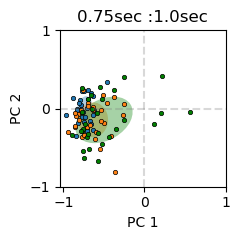

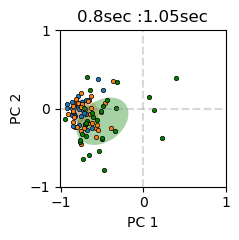

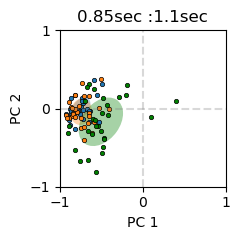

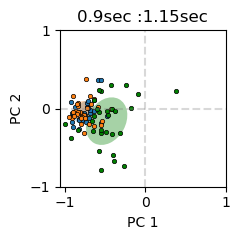

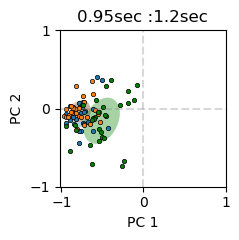

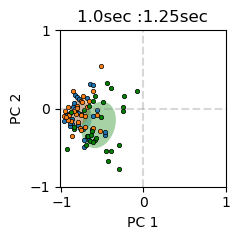

In [326]:
for shift in range(principal_components.shape[0]):
    
    data_pca = [a_pca[shift,:,:], b_pca[shift,:,:], c_pca[shift,:,:]]
    colors = ['#1F77B4', '#FF8113', 'green']
    names = ['alpha', 'beta', 'blank']

    fig, ax = plt.subplots(figsize=(2.5, 2.5))

    i = 0
    for data, color in zip(data_pca, colors):
        mean, cov = fit_gaussian(data)
        plot_ellipse(mean, cov, ax, color=color)
        i+=1

    i = 0
    for data, color in zip(data_pca, colors):
        # Plot data points
        ax.scatter(data[:, 0], data[:, 1], s=10, color=color, label=names[i], edgecolor='k',  linewidth=0.5)
        i+=1

    plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
    plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
    # plt.grid(True)
    # plt.axis('equal')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    # plt.ylim(-1,1)
    # plt.xlim(-1,1)
    plt.xticks([-1,  0,  1])
    plt.yticks([-1,  0,  1])
    # plt.title(f'Population responcses in PC space\nwindow {round(-1+shift*0.05 , 2)}sec :{round(-1+shift*0.05+0.25 , 2)}sec')
    plt.title(f'{round(-1+shift*0.05 , 2)}sec :{round(-1+shift*0.05+0.25 , 2)}sec')
    # plt.legend()
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\clusts\\({shift}){mouse}_S{Session}_{round(-1+shift*0.05 , 2)}_{round(-1+shift*0.05+0.25 , 2)}_1sd_norm_new.png', dpi=300, bbox_inches='tight')
    plt.show() 

### Mahalanobis

In [327]:
from scipy.spatial.distance import mahalanobis

In [328]:
# MD_matrix_all = np.zeros((principal_components.shape[0],3,3))

# for shift in range(principal_components.shape[0]):
#     # centroids
#     centroid_a_pca = np.mean(a_pca[shift,:,:], axis=0).reshape(1, -1)[0]
#     centroid_b_pca = np.mean(b_pca[shift,:,:], axis=0).reshape(1, -1)[0]
#     centroid_c_pca = np.mean(c_pca[shift,:,:], axis=0).reshape(1, -1)[0]

#     covar = np.cov(principal_components[shift,:,:].T)
#     covarinv = np.linalg.inv(covar)

#     MDic_a = [mahalanobis(x, centroid_a_pca, covarinv) for x in a_pca[shift,:,:]]
#     MDoc_ab = [mahalanobis(x, centroid_a_pca, covarinv) for x in b_pca[shift,:,:]]
#     MDoc_ac = [mahalanobis(x, centroid_a_pca, covarinv) for x in c_pca[shift,:,:]]

#     MDic_b = [mahalanobis(x, centroid_b_pca, covarinv) for x in b_pca[shift,:,:]]
#     MDoc_ba = [mahalanobis(x, centroid_b_pca, covarinv) for x in a_pca[shift,:,:]]
#     MDoc_bc = [mahalanobis(x, centroid_b_pca, covarinv) for x in c_pca[shift,:,:]]

#     MDic_c = [mahalanobis(x, centroid_c_pca, covarinv) for x in c_pca[shift,:,:]]
#     MDoc_ca = [mahalanobis(x, centroid_c_pca, covarinv) for x in a_pca[shift,:,:]]
#     MDoc_cb = [mahalanobis(x, centroid_c_pca, covarinv) for x in b_pca[shift,:,:]]

#     MD_matrix = np.zeros((3,3))

#     MD_matrix[0,0] = np.mean(np.array(MDic_a))
#     MD_matrix[0,1] = (np.mean(np.array(MDoc_ab))+np.mean(np.array(MDoc_ba)))/2
#     MD_matrix[0,2] = (np.mean(np.array(MDoc_ac))+np.mean(np.array(MDoc_ca)))/2

#     MD_matrix[1,0] = np.nan
#     MD_matrix[1,1] = np.mean(np.array(MDic_b))
#     MD_matrix[1,2] = (np.mean(np.array(MDoc_bc))+np.mean(np.array(MDoc_cb)))/2


#     MD_matrix[2,0] = np.nan
#     MD_matrix[2,1] = np.nan
#     MD_matrix[2,2] = np.mean(np.array(MDic_c))


#     MD_matrix_all[shift,:,:] = MD_matrix

In [329]:
MD_matrix_all = np.zeros((principal_components.shape[0],3,3))

for shift in range(principal_components.shape[0]):
    # centroids
    centroid_a_pca = np.mean(a_pca[shift,:,:], axis=0).reshape(1, -1)[0]
    centroid_b_pca = np.mean(b_pca[shift,:,:], axis=0).reshape(1, -1)[0]
    centroid_c_pca = np.mean(c_pca[shift,:,:], axis=0).reshape(1, -1)[0]

    covar = np.cov(principal_components[shift,:,:].T)
    covarinv = np.linalg.inv(covar)

    MDic_a = [mahalanobis(x, centroid_a_pca, covarinv) for x in a_pca[shift,:,:]]
    MDic_b = [mahalanobis(x, centroid_b_pca, covarinv) for x in b_pca[shift,:,:]]
    MDic_c = [mahalanobis(x, centroid_c_pca, covarinv) for x in c_pca[shift,:,:]]

    MDoc_ab = mahalanobis(centroid_a_pca, centroid_b_pca, covarinv)
    MDoc_ac = mahalanobis(centroid_a_pca, centroid_c_pca, covarinv)
    MDoc_bc = mahalanobis(centroid_b_pca, centroid_c_pca, covarinv)

    MD_matrix = np.zeros((3,3))
    MD_matrix[0,0] = np.mean(np.array(MDic_a))
    MD_matrix[0,1] = MDoc_ab
    MD_matrix[0,2] = MDoc_ac

    MD_matrix[1,0] = np.nan
    MD_matrix[1,1] = np.mean(np.array(MDic_b))
    MD_matrix[1,2] = MDoc_bc


    MD_matrix[2,0] = np.nan
    MD_matrix[2,1] = np.nan
    MD_matrix[2,2] = np.mean(np.array(MDic_c))


    MD_matrix_all[shift,:,:] = MD_matrix

In [330]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\{mouse}_S{Session}_MD_matrix_all.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(MD_matrix_all, f)

In [331]:
import math

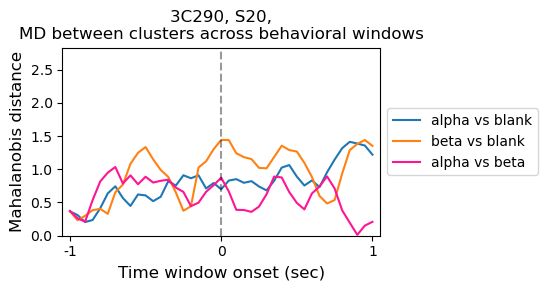

In [332]:
plt.figure(figsize=(4,3))
plt.plot(MD_matrix_all[:,0,2], label=f'alpha vs blank', color='#1F77B4')
plt.plot(MD_matrix_all[:,1,2], label=f'beta vs blank', color='#FF8113')
plt.plot(MD_matrix_all[:,0,1], label=f'alpha vs beta', color='#FF1493')
plt.axvline(20 ,color='black', linestyle='--', alpha=0.4)

plt.title(f'{mouse}, S{Session},\nMD between clusters across behavioral windows')
plt.ylabel('Mahalanobis distance',  fontsize=12)
plt.xlabel('Time window onset (sec)',  fontsize=12)

# plt.xticks(np.arange(principal_components.shape[0]), labels=xticks_labels_v2, rotation=45)
plt.xticks([0,20,40], labels=[-1,0,1])
# plt.yticks(fontsize=8)
plt.ylim(0, math.sqrt(8))
plt.xlim(-1,41)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\{mouse}_S{Session}_MD_shift_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## Euclidean distance

In [333]:
def euclidean(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [334]:
# ED_matrix_all = np.zeros((principal_components.shape[0],3,3))

# for shift in range(principal_components.shape[0]):
#     # centroids
#     centroid_a_pca = np.mean(a_pca[shift,:,:], axis=0).reshape(1, -1)[0]
#     centroid_b_pca = np.mean(b_pca[shift,:,:], axis=0).reshape(1, -1)[0]
#     centroid_c_pca = np.mean(c_pca[shift,:,:], axis=0).reshape(1, -1)[0]

#     MDic_a = [euclidean(x, centroid_a_pca) for x in a_pca[shift,:,:]]
#     MDoc_ab = [euclidean(x, centroid_a_pca) for x in b_pca[shift,:,:]]
#     MDoc_ac = [euclidean(x, centroid_a_pca) for x in c_pca[shift,:,:]]

#     MDic_b = [euclidean(x, centroid_a_pca) for x in b_pca[shift,:,:]]
#     MDoc_ba = [euclidean(x, centroid_a_pca) for x in a_pca[shift,:,:]]
#     MDoc_bc = [euclidean(x, centroid_a_pca) for x in c_pca[shift,:,:]]

#     MDic_c = [euclidean(x, centroid_a_pca) for x in c_pca[shift,:,:]]
#     MDoc_ca = [euclidean(x, centroid_a_pca) for x in a_pca[shift,:,:]]
#     MDoc_cb = [euclidean(x, centroid_a_pca) for x in b_pca[shift,:,:]]

#     MD_matrix = np.zeros((3,3))

#     MD_matrix[0,0] = np.mean(np.array(MDic_a))
#     MD_matrix[0,1] = (np.mean(np.array(MDoc_ab))+np.mean(np.array(MDoc_ba)))/2
#     MD_matrix[0,2] = (np.mean(np.array(MDoc_ac))+np.mean(np.array(MDoc_ca)))/2

#     MD_matrix[1,0] = np.nan
#     MD_matrix[1,1] = np.mean(np.array(MDic_b))
#     MD_matrix[1,2] = (np.mean(np.array(MDoc_bc))+np.mean(np.array(MDoc_cb)))/2


#     MD_matrix[2,0] = np.nan
#     MD_matrix[2,1] = np.nan
#     MD_matrix[2,2] = np.mean(np.array(MDic_c))


#     ED_matrix_all[shift,:,:] = MD_matrix

In [335]:
ED_matrix_all = np.zeros((principal_components.shape[0],3,3))

for shift in range(principal_components.shape[0]):
    # centroids
    centroid_a_pca = np.mean(a_pca[shift,:,:], axis=0).reshape(1, -1)[0]
    centroid_b_pca = np.mean(b_pca[shift,:,:], axis=0).reshape(1, -1)[0]
    centroid_c_pca = np.mean(c_pca[shift,:,:], axis=0).reshape(1, -1)[0]

    EDic_a = [euclidean(x, centroid_a_pca) for x in a_pca[shift,:,:]]
    EDic_b = [euclidean(x, centroid_b_pca) for x in b_pca[shift,:,:]]
    EDic_c = [euclidean(x, centroid_c_pca) for x in c_pca[shift,:,:]]


    EDoc_ab = euclidean(centroid_a_pca, centroid_b_pca) 
    EDoc_ac = euclidean(centroid_a_pca, centroid_c_pca) 
    EDoc_bc = euclidean(centroid_b_pca, centroid_c_pca)


    ED_matrix = np.zeros((3,3))
    ED_matrix[0,0] = np.mean(np.array(EDic_a))
    ED_matrix[0,1] = EDoc_ab
    ED_matrix[0,2] = EDoc_ac

    ED_matrix[1,0] = np.nan
    ED_matrix[1,1] = np.mean(np.array(EDic_b))
    ED_matrix[1,2] = EDoc_bc


    ED_matrix[2,0] = np.nan
    ED_matrix[2,1] = np.nan
    ED_matrix[2,2] = np.mean(np.array(EDic_c))


    ED_matrix_all[shift,:,:] = ED_matrix

In [336]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\{mouse}_S{Session}_ED_matrix_all.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(ED_matrix_all, f)

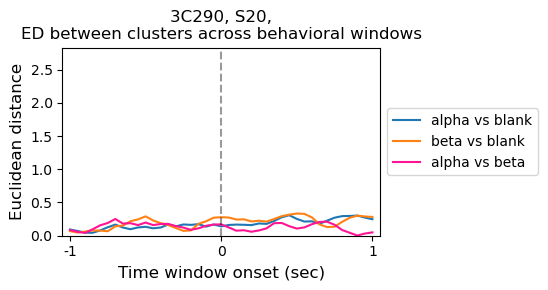

In [337]:
plt.figure(figsize=(4,3))
plt.plot(ED_matrix_all[:,0,2], label=f'alpha vs blank', color='#1F77B4')
plt.plot(ED_matrix_all[:,1,2], label=f'beta vs blank', color='#FF8113')
plt.plot(ED_matrix_all[:,0,1], label=f'alpha vs beta', color='#FF1493')
plt.axvline(20 ,color='black', linestyle='--', alpha=0.4)

plt.title(f'{mouse}, S{Session},\nED between clusters across behavioral windows')
plt.ylabel('Euclidean distance',  fontsize=12)
plt.xlabel('Time window onset (sec)',  fontsize=12)

# plt.xticks(np.arange(principal_components.shape[0]), labels=xticks_labels_v2, rotation=45)
plt.xticks([0,20,40], labels=[-1,0,1])
# plt.yticks(fontsize=8)
plt.ylim(0, math.sqrt(8))
plt.xlim(-1,41)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\{mouse}_S{Session}_ED_shift_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## Classifiers

In [338]:
# Importing necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from scipy.stats import percentileofscore

In [339]:
def SVM_morning(alpha_data, beta_data, kernel = 'linear', cv=5):

    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = int(num_rows*0.2) #20 percent

    # collect outcomes
    accuracy_cv5 = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        # Standardize the data
        scaler = StandardScaler()
        test_ab = scaler.fit_transform(test_ab)
        train_ab = scaler.fit_transform(train_ab)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel, random_state=666)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred)) 

    return np.mean(np.array(accuracy_cv5)) 

In [340]:
def bayes_morning(alpha_data, beta_data, cv=5):

    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = int(num_rows*0.2) #20 percent

    accuracy_cv5 = []

    for n in range(cv):

        # data prep
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        # dataset
        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)
        
        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        # actual prediction
        classifier = GaussianNB()
        classifier.fit(train_ab, y_train)
        y_pred = classifier.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred))

    return np.mean(np.array(accuracy_cv5))     

In [341]:
SVM_sbl = []
bayes_sbl = []

SVM_ab = []
bayes_ab = []

for shift in range(len(shift_list)):

    # Data prep
    fr_dic = shift_list[shift]
    
    alpha_data = fr_dic[a_idx]
    beta_data = fr_dic[b_idx]
    blank_data = fr_dic[bl_idx]

    num_rows = alpha_data.shape[0]
    shuffled_indices = list(range(num_rows))

    random.shuffle(shuffled_indices)
    alpha_data = alpha_data[shuffled_indices]

    random.shuffle(shuffled_indices)
    beta_data = beta_data[shuffled_indices]

    num_rows = alpha_data.shape[0]
    social_data = np.concatenate((alpha_data[:int(num_rows/2),:], beta_data[int(num_rows/2):,:]), axis=0)

    random.shuffle(shuffled_indices)
    blank_data = blank_data[shuffled_indices]

    ## SVM
    SVM_ab.append(SVM_morning(alpha_data, beta_data))
    SVM_sbl.append(SVM_morning(social_data, blank_data))
    ## bayes
    bayes_ab.append(bayes_morning(alpha_data, beta_data))
    bayes_sbl.append(bayes_morning(social_data, blank_data))

In [342]:
shift_models_dic = {}

shift_models_dic['SVM_sbl'] = SVM_sbl
shift_models_dic['bayes_sbl'] = bayes_sbl
shift_models_dic['SVM_ab'] = SVM_ab
shift_models_dic['bayes_ab'] = bayes_ab


In [343]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\{mouse}_S{Session}_classifiers_results_shift.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(shift_models_dic, f)

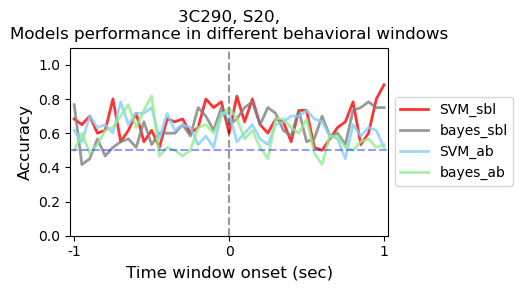

In [344]:
dics = [SVM_sbl,bayes_sbl,SVM_ab,bayes_ab]
dic_names = ['SVM_sbl', 'bayes_sbl', 'SVM_ab', 'bayes_ab']
colors = ['red', '#808080', '#87CEFA', '#90EE90']

plt.figure(figsize=(4,3)) 
for i in range(len(dics)):
    plt.plot(dics[i], color=colors[i], alpha=0.8, label=dic_names[i], linewidth=2)
plt.axvline(20 ,color='black', linestyle='--', alpha=0.4)
plt.axhline(0.5 ,color='blue', linestyle='--', alpha=0.4)

plt.xlabel('Time window onset (sec)',  fontsize=12)
plt.ylabel('Accuracy',  fontsize=12)
plt.title(f'{mouse}, S{Session},\nModels performance in different behavioral windows')
plt.xticks([0,20,40], labels=[-1,0,1])
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-0.5, len(shift_list)-0.5)
plt.ylim(0,1.1)
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\window_shift\\S{Session}\\{mouse}_S{Session}_models_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()